In [1]:
from os import listdir
from os.path import isfile,join
import requests

billPath = '../bills/'
url = "http://localhost:9200"
bills = [f for f in listdir(billPath) if isfile(join(billPath, f))]
tags = []

bigrams = {}
singlegrams = {}

counter = 0

for b in bills:
    bPath = billPath + b
    f = open(bPath,encoding='utf-8')
    content = f.read()
    
    # assuming that lower won't affect result in a bad way
    content = content.lower()
    res = requests.post(url, data=content.encode('utf-8'))
    
    lines = res.text.splitlines()
    
    g1 = ""
    g2 = ""
    
    for i in range(len(lines)):
        split = lines[i].split()
        if len(split) != 3:
            continue
        
        word = split[0]
        tag = split[1].split(':')[0]
        
        g2 = g1
        g1 = (word,tag)
        
        #siglegrams
        x = singlegrams.get(g1,0)
        singlegrams[g1] = x + 1
        
        #bigrams
        if g2 != '':
            x = bigrams.get((g2,g1),0)
            bigrams[(g2,g1)] = x + 1
        
        #without stats
        tags.append((word,tag))
#     counter += 1
#     if counter == 10:
#         break
        
    
    

In [2]:
def fremove(t):
    import regex as re
    tmp = re.search(r"\p{L}+",t)
    if tmp is None or len(tmp.group(0)) != len(t):
        return True
    return False

to_remove = []
for b in bigrams:
    g1,g2 = b
    w1, t1 = g1
    w2, t2 = g2
    
    if fremove(w1) or fremove(w2):
        to_remove.append(b)

len(to_remove)


118829

In [3]:
len(bigrams)

483856

In [4]:
for r in to_remove:
    bigrams.pop(r)

In [5]:
from math import log
import numpy as np

# Data

all_occurences = 0
for i in bigrams:
    all_occurences += bigrams[i]

bigrams_with_LLR = {}

def H(args,N):
    s = 0
    for a in args:
        a /= N
        one = 1 if a == 0 else 0
        s += a * log(a + one)
    return s

def LLR_bigram(t1,t2,N):
    t1,t2 = i
    N = all_occurences
    
    k11 = (bigrams[(t1,t2)])
    k12 = (singlegrams[t2] - k11)
    k21 = (singlegrams[t1] - k11)
    k22 = (all_occurences - k11 - k12 - k21)
    
    return 2 * N * (H([k11,k12,k21,k22],N) - H([k11+k12,k21+k22],N) - H([k11+k21,k12+k22],N))
    
N = all_occurences
for i in bigrams:
    t1,t2 = i    
    
    LLR = LLR_bigram(t1,t2,N)
    bigrams_with_LLR[(t1,t2)] = LLR
    

In [6]:
list_LLR = []
for i in bigrams_with_LLR:
    list_LLR.append([i,bigrams_with_LLR[i]])
list_LLR.sort(key=lambda a: -a[1])
list_LLR[0:10]

[[(('który', 'adj'), ('mowa', 'subst')), 248323.47813489943],
 [(('o', 'prep'), ('który', 'adj')), 163662.8380830866],
 [(('mowa', 'subst'), ('w', 'prep')), 149478.78490378824],
 [(('otrzymywać', 'fin'), ('brzmienie', 'subst')), 111105.82963924854],
 [(('minister', 'subst'), ('właściwy', 'adj')), 67763.46033475136],
 [(('w', 'prep'), ('artykuł', 'brev')), 67751.07338376575],
 [(('dodawać', 'fin'), ('się', 'qub')), 66927.24815087883],
 [(('w', 'prep'), ('ustęp', 'brev')), 56401.460472486884],
 [(('stosować', 'fin'), ('się', 'qub')), 52971.0157973974],
 [(('droga', 'subst'), ('rozporządzenie', 'subst')), 51680.8027317483]]

In [7]:
bigram_tags = {}

for i in bigrams:
#     print(i)
    v = bigrams[i]
    g1,g2 = i
    w1, t1 = g1
    w2, t2 = g2
    
    x = bigram_tags.get((t1,t2),0)
    bigram_tags[t1,t2] = x + v
    
list_bigram_tags = []
for i in bigram_tags:
#     print(i)
    list_bigram_tags.append([i,bigram_tags[i]])
list_bigram_tags.sort(key=lambda a: -a[1])
top_10_tags = list_bigram_tags[0:10]
top_10_tags

[[('prep', 'subst'), 327378],
 [('subst', 'subst'), 290104],
 [('subst', 'adj'), 274761],
 [('adj', 'subst'), 188238],
 [('subst', 'prep'), 173254],
 [('subst', 'conj'), 85145],
 [('conj', 'subst'), 84393],
 [('prep', 'adj'), 79459],
 [('ger', 'subst'), 77510],
 [('prep', 'brev'), 67230]]

In [8]:
top_LLR_for_tags = {}
for i in top_10_tags:
    t,v = i
    tag1,tag2 = t
    top_5 = []
    for b in list_LLR:
        tmp,LLR = b
        g1,g2 = tmp
        w1, t1 = g1
        w2, t2 = g2
        if t1 == tag1 and t2 == tag2:
            top_5.append((g1,g2,LLR))
            if len(top_5) == 5:
                top_LLR_for_tags[t1,t2] = top_5
                break

In [9]:
for k in top_LLR_for_tags:
    print(k)
    for i in top_LLR_for_tags[k]:
        print("\t" + str(i))
    print("\n")

('prep', 'subst')
	(('na', 'prep'), ('podstawa', 'subst'), 45477.310954122746)
	(('do', 'prep'), ('sprawa', 'subst'), 45252.30316708258)
	(('z', 'prep'), ('dzień', 'subst'), 43159.23405404215)
	(('w', 'prep'), ('droga', 'subst'), 31358.799272838856)
	(('od', 'prep'), ('dzień', 'subst'), 29493.159003393183)


('subst', 'subst')
	(('droga', 'subst'), ('rozporządzenie', 'subst'), 51680.8027317483)
	(('skarb', 'subst'), ('państwo', 'subst'), 21817.45586219784)
	(('rada', 'subst'), ('minister', 'subst'), 14668.755602848223)
	(('terytorium', 'subst'), ('rzeczpospolita', 'subst'), 14126.997805359082)
	(('ochrona', 'subst'), ('środowisko', 'subst'), 13839.313197740266)


('subst', 'adj')
	(('minister', 'subst'), ('właściwy', 'adj'), 67763.46033475136)
	(('rzeczpospolita', 'subst'), ('polski', 'adj'), 43011.304981795365)
	(('jednostka', 'subst'), ('organizacyjny', 'adj'), 23994.10394401504)
	(('samorząd', 'subst'), ('terytorialny', 'adj'), 23146.147887406274)
	(('produkt', 'subst'), ('leczniczy

# Using the results from the previous step answer the following questions:
    1) What types of bigrams have been found?
        With most LLR score:
    
        ('który', 'adj'),       ('mowa', 'subst'),          248323.47813489943,
        ('o', 'prep'),          ('który', 'adj'),           163662.8380830866,
        ('mowa', 'subst'),      ('w', 'prep'),              149478.78490378824,
        ('otrzymywać', 'fin'),  ('brzmienie', 'subst'),     111105.82963924854,
        ('minister', 'subst'),  ('właściwy', 'adj'),        67763.46033475136,
        ('w', 'prep'),          ('artykuł', 'brev'),        67751.07338376575,
        ('dodawać', 'fin'),     ('się', 'qub'),             66927.24815087883,
        ('w', 'prep'),          ('ustęp', 'brev'),          56401.460472486884,
        ('stosować', 'fin'),    ('się', 'qub'),             52971.0157973974,
        ('droga', 'subst'),     ('rozporządzenie', 'subst'),51680.8027317483
        
        These bigrams are very commonly used in law language. We can notice basic form of words.
        For me the only suprising bigram is minister właściwy.
        Comparing to previous result we can see less repetitions like: "ktorych mowa" "ktorym mowa" this two were merged 
        into the one of the same meaning 'ktory mowa'
        
    
    2) Which of the category-pairs indicate valuable multiword expressions? Do they have anything in common?
        I think that majorityh of them is usefull apart from:
        1) ('prep', 'brev')
        2) ('conj', 'subst')
        3) ('subst', 'conj')
        
        They mostly include one letter words such as 'i', 'w'.
    
    
    
    3) Which signal: LLR score or syntactic category is more useful for determining genuine multiword expressions?
        There is no easy answer but I would search for the biggest LLR score amonge some of categories. 
        So I would say that category is more impoertant
    
    
    
    4) Can you describe a different use-case where the morphosyntactic category is useful for resolving a real-world problem?
        For searching in browser or among internet shops.
        For example to identify subject in the sentence.
        The other possibility is to use it somehow in AI but I have not tried or seen it.
        
    5) Previouse excerciese was on time in teams but not handed in.... Here picture to prove my words. It is easier to believe that because the next task will be several minutes after the previous one, while running it last for more than two houres.
    I know it won't change result but just want to share my disappointment with you about double accaptance to place homework (in contrast to upel where it is not needed).
    
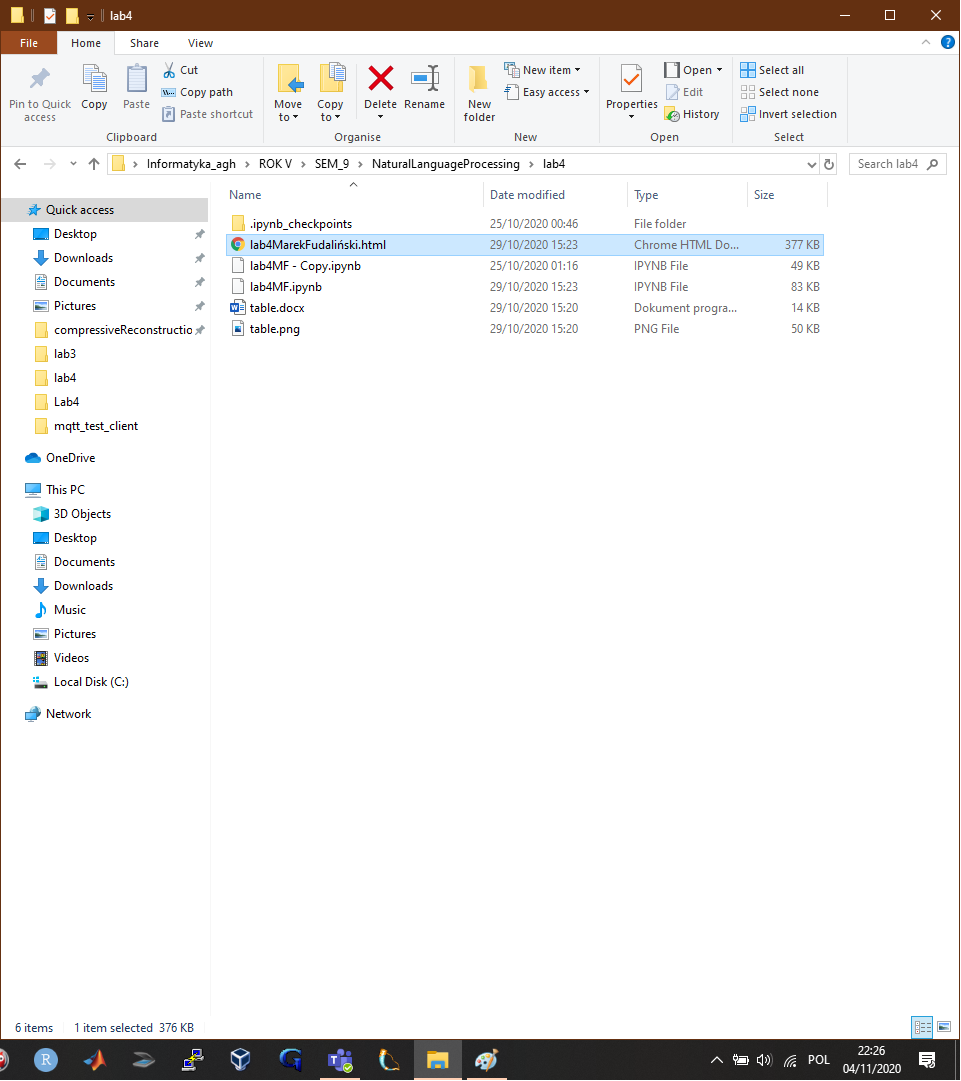
    